### Funcionou com 36 posições, estavel mais nao calculado no fitness

In [1]:
import random
import numpy as np
import pandas as pd

# Constantes de Estabilidade
KM = 12  # Altura do metacentro acima da quilha em metros
KG = 8   # Altura inicial do centro de gravidade em metros
MIN_GM = 0.5  # Mínimo valor permitido para GM em metros
MAX_HEEL = 5  # Máximo valor permitido para inclinação lateral em graus
MAX_TRIM = 2  # Máximo valor permitido para inclinação longitudinal em graus
CAPACIDADE_MAXIMA = 550  # Capacidade máxima da balsa em toneladas

# Função para calcular a estabilidade
def calcular_estabilidade(containers):
    peso_total = sum(peso for peso, _, _, _ in containers)
    centro_gravidade_z = sum(peso * z for peso, _, _, z in containers) / peso_total
    GM = KM - centro_gravidade_z
    heel = sum(peso * x for peso, x, _, _ in containers) / (peso_total * 10)
    trim = sum(peso * y for peso, _, y, _ in containers) / (peso_total * 10)
    
    if GM < MIN_GM or abs(heel) > MAX_HEEL or abs(trim) > MAX_TRIM:
        return False, GM, heel, trim
    return True, GM, heel, trim

# Função modificada para incluir cálculo de estabilidade
def preencher_porto(df_cromossomo):
    # Inicializar o porto e balsa
    porto = np.zeros((2, 5, 3), dtype=int)
    balsa = np.zeros((3, 4, 3), dtype=int)
    porto_preenchido = np.ones((2, 5, 3), dtype=int)
    cal_movimentos = 0
    
    # Preencher o porto com os dados do cromossomo
    ordem_inicial = []
    ordem_final = []

    df_cromossomo = df_cromossomo.sort_values(by='Posição Inicial')
    for _, linha in df_cromossomo.iterrows():
        ordem_inicial.append(linha['Container'])
    idx = 0
    for andar in range(2):
        for x in range(5):
            for y in range(3):
                if idx < 30:
                    porto[andar, x, y] = ordem_inicial[idx]
                    idx += 1
    
    df_cromossomo = df_cromossomo.sort_values(by='Ordem de Movimentação')
    containers = []
    

    errou = 0
    pode_mover = True
    # Realizar movimentações
    for _, linha in df_cromossomo.iterrows():
        container = linha['Container']
        a_pos_inicial = linha['Posição Inicial']
        a_pos_final = linha['Posição Final']
        pos_inicial = linha['Posição Inicial'] 
        pos_final = linha['Posição Final'] 
        
        andar_ini, x_ini, y_ini = pos_inicial // 15, (pos_inicial % 15) // 3, (pos_inicial % 15) % 3
        andar_fin, x_fin, y_fin = pos_final // 12, (pos_final % 12) // 3, (pos_final % 12) % 3
        
        

        if (errou==0):
            
            # Verificar se podemos remover do porto preenchido
            if andar_ini < 1:
                if porto_preenchido[andar_ini + 1, x_ini, y_ini] == 1:
                    errou =1
                    pode_mover = False
            
            # Verificar se podemos adicionar à balsa
            if andar_fin > 0:
                if balsa[andar_fin - 1, x_fin, y_fin] == 0:
                    errou =1
                    pode_mover = False

            # Verifica se o lugar está ocupado
            if balsa[andar_fin , x_fin, y_fin] == 1:
                errou =1
                pode_mover = False

                    
            if pode_mover:
                # Atualizar porto_preenchido e balsa
                porto_preenchido[andar_ini, x_ini, y_ini] = 0
                balsa[andar_fin, x_fin, y_fin] = 1
                
                cal_movimentos += 2 #alturas subir e descer
                cal_movimentos += 0 if x_ini == x_fin else 1  # verificação x
                cal_movimentos += 0 if y_ini == y_fin else 1  # verificação y
                
                # Adicionar contêiner à lista
                peso_container = 10  # Supondo peso fixo de 10 toneladas por contêiner
                containers.append((peso_container, x_fin, y_fin, andar_fin * 2.6))  # Altura simplificada

                estavel, GM, heel, trim = calcular_estabilidade(containers)
                if not estavel:
                    errou =1
                    pode_mover = False # Penalidade para cromossomos instáveis
            else:
                cal_movimentos += 1000
        else:
            cal_movimentos += 1000

    
    return cal_movimentos

# Funções do algoritmo genético (permanecem iguais, apenas chamam a função modificada)
def gerar_cromossomo():
    cromossomo = []
    
    # Gera posições iniciais (0-29)
    posicoes_iniciais = list(range(30))
    random.shuffle(posicoes_iniciais)
    cromossomo.extend(posicoes_iniciais)
    

    posicoes_finais = list(range(36))
    random.shuffle(posicoes_finais)
    posicoes_finais = posicoes_finais[:30]
    cromossomo.extend(posicoes_finais)

    
    # Gera ordem de movimentação (0-29)
    ordem_movimentacao = list(range(30))
    random.shuffle(ordem_movimentacao)
    cromossomo.extend(ordem_movimentacao)
    
    return cromossomo

def cromossomo_para_dataframe(cromossomo):
    container = list(range(30))
    posicao_inicial = cromossomo[:30]
    posicao_final = cromossomo[30:60]
    ordem_movimentacao = cromossomo[60:90]
    
    df = pd.DataFrame({
        'Container': container,
        'Posição Inicial': posicao_inicial,
        'Posição Final': posicao_final,
        'Ordem de Movimentação': ordem_movimentacao
    })
        
    df = df.sort_values(by='Ordem de Movimentação')
    
    return df

def inicializar_populacao(tamanho_populacao):
    populacao = []
    for _ in range(tamanho_populacao):
        cromossomo = gerar_cromossomo()
        populacao.append(cromossomo)
    return populacao

def verifica_repetidos(cromossomo):
    intervalos = [
        (0, 29),
        (30, 59),
        (60, 89)
    ]
    
    for intervalo in intervalos:
        valores = cromossomo[intervalo[0]:intervalo[1]+1]
        if len(valores) != len(set(valores)):
            return True
    
    return False

def selecao_roleta(populacao, fitness):
    soma_fitness = sum(fitness)
    pick = random.uniform(0, soma_fitness)
    atual = 0
    for cromossomo, fit in zip(populacao, fitness):
        atual += fit
        if atual >= pick:
            return cromossomo

def cruzamento_pmx(pai1, pai2, inicio, fim):
    tamanho = fim - inicio + 1
    filho1 = pai1[:inicio] + [-1] * tamanho + pai1[fim+1:]
    filho2 = pai2[:inicio] + [-1] * tamanho + pai2[fim+1:]
    
    mapeamento1 = pai1[inicio:fim+1]
    mapeamento2 = pai2[inicio:fim+1]
    
    # Copiar o segmento
    filho1[inicio:fim+1] = mapeamento2
    filho2[inicio:fim+1] = mapeamento1
    
    # Resolver conflitos para filho1
    for i in range(inicio):
        if filho1[i] in mapeamento2:
            idx = mapeamento2.index(filho1[i])
            while mapeamento1[idx] in mapeamento2:
                idx = mapeamento2.index(mapeamento1[idx])
            filho1[i] = mapeamento1[idx]
    
    for i in range(fim+1, len(pai1)):
        if filho1[i] in mapeamento2:
            idx = mapeamento2.index(filho1[i])
            while mapeamento1[idx] in mapeamento2:
                idx = mapeamento2.index(mapeamento1[idx])
            filho1[i] = mapeamento1[idx]
    
    # Resolver conflitos para filho2
    for i in range(inicio):
        if filho2[i] in mapeamento1:
            idx = mapeamento1.index(filho2[i])
            while mapeamento2[idx] in mapeamento1:
                idx = mapeamento1.index(mapeamento2[idx])
            filho2[i] = mapeamento2[idx]
    
    for i in range(fim+1, len(pai2)):
        if filho2[i] in mapeamento1:
            idx = mapeamento1.index(filho2[i])
            while mapeamento2[idx] in mapeamento1:
                idx = mapeamento1.index(mapeamento2[idx])
            filho2[i] = mapeamento2[idx]
    
    return filho1, filho2

def cruzamento(pai, mae):
    filho1, filho2 = pai[:], mae[:]
    
    ponto_corte1 = random.randint(0, 29)
    ponto_corte2 = random.randint(0, 29)
    inicio, fim = min(ponto_corte1, ponto_corte2), max(ponto_corte1, ponto_corte2)
    filho1[:30], filho2[:30] = cruzamento_pmx(pai[:30], mae[:30], inicio, fim)
    
    ponto_corte1 = random.randint(30, 59)
    ponto_corte2 = random.randint(30, 59)
    inicio, fim = min(ponto_corte1, ponto_corte2) - 30, max(ponto_corte1, ponto_corte2) - 30
    filho1[30:60], filho2[30:60] = cruzamento_pmx(pai[30:60], mae[30:60], inicio, fim)
    
    ponto_corte1 = random.randint(60, 89)
    ponto_corte2 = random.randint(60, 89)
    inicio, fim = min(ponto_corte1, ponto_corte2) - 60, max(ponto_corte1, ponto_corte2) - 60
    filho1[60:90], filho2[60:90] = cruzamento_pmx(pai[60:90], mae[60:90], inicio, fim)
    
    return filho1, filho2

def mutacao(cromossomo, taxa_mutacao=0.01):
    if random.random() < taxa_mutacao:
        part = random.randint(0, 2)
        idx1, idx2 = random.sample(range(30), 2)
        if part == 0:
            cromossomo[idx1], cromossomo[idx2] = cromossomo[idx2], cromossomo[idx1]
        elif part == 1:
            cromossomo[30+idx1], cromossomo[30+idx2] = cromossomo[30+idx2], cromossomo[30+idx1]
        else:
            cromossomo[60+idx1], cromossomo[60+idx2] = cromossomo[60+idx2], cromossomo[60+idx1]
    return cromossomo

def algoritmo_genetico(tamanho_populacao, taxa_mutacao):
    populacao = inicializar_populacao(tamanho_populacao)
    fitness = [preencher_porto(cromossomo_para_dataframe(cromossomo)) for cromossomo in populacao]
    
    melhor_fit = min(fitness)
    contagem_repeticoes = 0
    geracao = 0
    
    geracoes = []
    melhor_fitness = []
    fitness_min = []
    fitness_max = []
    fitness_medio = []

    while contagem_repeticoes < 50:
        geracoes.append(geracao)
        melhor_fitness.append(melhor_fit)
        fitness_min.append(min(fitness))
        fitness_max.append(max(fitness))
        fitness_medio.append(np.mean(fitness))
        
        nova_populacao = []
        while len(nova_populacao) < tamanho_populacao:
            pai = selecao_roleta(populacao, fitness)
            mae = selecao_roleta(populacao, fitness)
            
            filho1, filho2 = cruzamento(pai, mae)
            filho1 = mutacao(filho1, taxa_mutacao)
            filho2 = mutacao(filho2, taxa_mutacao)
            
            nova_populacao.append(filho1)
            nova_populacao.append(filho2)
        
        # Combinar 5% melhor da geração antiga com a melhor nova geração
        populacao.extend(nova_populacao)
        fitness = [preencher_porto(cromossomo_para_dataframe(cromossomo)) for cromossomo in populacao]
        
        # Ordenar pela fitness e selecionar os melhores
        populacao_ordenada = sorted(zip(populacao, fitness), key=lambda x: x[1])
        
        melhor_5_porcento = int(tamanho_populacao * 0.05)
        nova_metade = tamanho_populacao - melhor_5_porcento
        
        populacao = [cromossomo for cromossomo, _ in populacao_ordenada[:melhor_5_porcento]] + [cromossomo for cromossomo, _ in populacao_ordenada[melhor_5_porcento:melhor_5_porcento+nova_metade]]
        fitness = [fit for _, fit in populacao_ordenada[:melhor_5_porcento]] + [fit for _, fit in populacao_ordenada[melhor_5_porcento:melhor_5_porcento+nova_metade]]
        
        novo_melhor_fit = min(fitness)
        if novo_melhor_fit == melhor_fit:
            contagem_repeticoes += 1
        else:
            melhor_fit = novo_melhor_fit
            contagem_repeticoes = 0
        
        geracao += 1
        print(f"Geração {geracao}: Melhor fitness = {melhor_fit}, Repetições = {contagem_repeticoes}")
    
    melhor_cromossomo = populacao[fitness.index(min(fitness))]
    
    return melhor_cromossomo, min(fitness), geracoes, melhor_fitness, fitness_min, fitness_max, fitness_medio

# Configurações
tamanho_populacao = 100
taxa_mutacao = 0.1

melhor_cromossomo, melhor_fit, geracoes, melhor_fitness, fitness_min, fitness_max, fitness_medio = algoritmo_genetico(tamanho_populacao, taxa_mutacao)
print(f"Melhor cromossomo encontrado: {melhor_cromossomo}")
print(f"Melhor fitness: {melhor_fit}")



Geração 1: Melhor fitness = 26015, Repetições = 0
Geração 2: Melhor fitness = 26015, Repetições = 1
Geração 3: Melhor fitness = 26015, Repetições = 2
Geração 4: Melhor fitness = 25020, Repetições = 0
Geração 5: Melhor fitness = 25020, Repetições = 1
Geração 6: Melhor fitness = 25020, Repetições = 2
Geração 7: Melhor fitness = 25019, Repetições = 0
Geração 8: Melhor fitness = 25019, Repetições = 1
Geração 9: Melhor fitness = 25017, Repetições = 0
Geração 10: Melhor fitness = 25017, Repetições = 1
Geração 11: Melhor fitness = 25017, Repetições = 2
Geração 12: Melhor fitness = 25017, Repetições = 3
Geração 13: Melhor fitness = 25017, Repetições = 4
Geração 14: Melhor fitness = 25017, Repetições = 5
Geração 15: Melhor fitness = 25017, Repetições = 6
Geração 16: Melhor fitness = 25017, Repetições = 7
Geração 17: Melhor fitness = 25017, Repetições = 8
Geração 18: Melhor fitness = 25017, Repetições = 9
Geração 19: Melhor fitness = 25015, Repetições = 0
Geração 20: Melhor fitness = 25015, Repe

#### Verifica se ha numeros repetidos


In [3]:
def verifica_repetidos(cromossomo):
    intervalos = [
        (0, 29),
        (30, 59),
        (60, 89)
    ]
    
    for intervalo in intervalos:
        valores = cromossomo[intervalo[0]:intervalo[1]+1]
        if len(valores) != len(set(valores)):
            return True
    
    return False

if verifica_repetidos(melhor_cromossomo):
    print("Valores repetidos encontrados!")
else:
    print("Não há valores repetidos.")

df_cromossomo = cromossomo_para_dataframe(melhor_cromossomo)
print("DataFrame do Cromossomo:")
print(df_cromossomo)


Não há valores repetidos.
DataFrame do Cromossomo:
    Container  Posição Inicial  Posição Final  Ordem de Movimentação
21         21               17              2                      0
12         12               25             10                      1
19         19               16              1                      2
1           1               26             14                      3
24         24               21              6                      4
17         17               19              4                      5
23         23               15              0                      6
3           3               27              5                      7
4           4               18              3                      8
26         26               23             26                      9
14         14               11             11                     10
9           9               22              7                     11
5           5                2             13       

### Simular Melhor cromomossomo

In [4]:
def Simular_preencher_porto(df_cromossomo):
    # Inicializar o porto e balsa
    porto = np.zeros((2, 5, 3), dtype=int)
    balsa = np.zeros((3, 4, 3), dtype=int)
    porto_preenchido = np.ones((2, 5, 3), dtype=int)
    cal_movimentos = 0
    
    # Preencher o porto com os dados do cromossomo
    ordem_inicial = []
    ordem_final = []

    df_cromossomo = df_cromossomo.sort_values(by='Posição Inicial')
    for _, linha in df_cromossomo.iterrows():
        ordem_inicial.append(linha['Container'])
    idx = 0
    for andar in range(2):
        for x in range(5):
            for y in range(3):
                if idx < 30:
                    porto[andar, x, y] = ordem_inicial[idx]
                    idx += 1
    
    df_cromossomo = df_cromossomo.sort_values(by='Ordem de Movimentação')
    containers = []
    
    # Realizar movimentações
    for _, linha in df_cromossomo.iterrows():
        container = linha['Container']
        a_pos_inicial = linha['Posição Inicial']
        a_pos_final = linha['Posição Final']
        pos_inicial = linha['Posição Inicial'] 
        pos_final = linha['Posição Final'] 
        
        andar_ini, x_ini, y_ini = pos_inicial // 15, (pos_inicial % 15) // 3, (pos_inicial % 15) % 3
        andar_fin, x_fin, y_fin = pos_final // 12, (pos_final % 12) // 3, (pos_final % 12) % 3
        
        errou = 0
        pode_mover = True

        if (errou==0):
            
            # Verificar se podemos remover do porto preenchido
            if andar_ini < 1:
                if porto_preenchido[andar_ini + 1, x_ini, y_ini] == 1:
                    errou =1
                    pode_mover = False
            
            # Verificar se podemos adicionar à balsa
            if andar_fin > 0:
                if balsa[andar_fin - 1, x_fin, y_fin] == 0:
                    errou =1
                    pode_mover = False

            # Verifica se o lugar está ocupado
            if balsa[andar_fin , x_fin, y_fin] == 1:
                errou =1
                pode_mover = False

                    
            if pode_mover:
                # Atualizar porto_preenchido e balsa
                porto_preenchido[andar_ini, x_ini, y_ini] = 0
                balsa[andar_fin, x_fin, y_fin] = 1
                
                cal_movimentos += 2 #alturas subir e descer
                cal_movimentos += 0 if x_ini == x_fin else 1  # verificação x
                cal_movimentos += 0 if y_ini == y_fin else 1  # verificação y
                
                # Adicionar contêiner à lista
                peso_container = 10  # Supondo peso fixo de 10 toneladas por contêiner
                containers.append((peso_container, x_fin, y_fin, 1))  # Altura simplificada

                estavel, GM, heel, trim = calcular_estabilidade(containers)

                print(f"Movendo container {container} de ({a_pos_inicial})({pos_inicial})({andar_ini}, {x_ini}, {y_ini}) para ({a_pos_final})({pos_final})({andar_fin}, {x_fin}, {y_fin})")
                print(f"Estabilidade {estavel}: GM->({GM}) heel->({heel}) trim->({trim})")
                print("Estado atual do Porto Preenchido:")
                print(porto_preenchido)
                print("Estado atual da Balsa:")
                print(balsa)
                print("\n")

                if not estavel:
                    errou =1
                    pode_mover = False # Penalidade para cromossomos instáveis
            else:
                print(f"não moveu container {container} de ({a_pos_inicial})({pos_inicial})({andar_ini}, {x_ini}, {y_ini}) para ({a_pos_final})({pos_final})({andar_fin}, {x_fin}, {y_fin})")
                cal_movimentos += 1000
        else:
            cal_movimentos += 1000


Simular_preencher_porto(cromossomo_para_dataframe(melhor_cromossomo))

Movendo container 21 de (17)(17)(1, 0, 2) para (2)(2)(0, 0, 2)
Estabilidade True: GM->(11.0) heel->(0.0) trim->(0.2)
Estado atual do Porto Preenchido:
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 0]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]]
Estado atual da Balsa:
[[[0 0 1]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Movendo container 12 de (25)(25)(1, 3, 1) para (10)(10)(0, 3, 1)
Estabilidade True: GM->(11.0) heel->(0.15) trim->(0.15)
Estado atual do Porto Preenchido:
[[[1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 0]
  [1 1 1]
  [1 1 1]
  [1 0 1]
  [1 1 1]]]
Estado atual da Balsa:
[[[0 0 1]
  [0 0 0]
  [0 0 0]
  [0 1 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


Movendo container 19 de (16)(16)(1, 0, 1) para (1)(1)(0, 0, 1)
Estabilidade True: GM->(11.0) heel->(0.1) trim->(0.13333333333333333)
Estado atual do Porto Preenchido:
[[[1 1 1]
  [1 1 

### Plotagem de Graficos

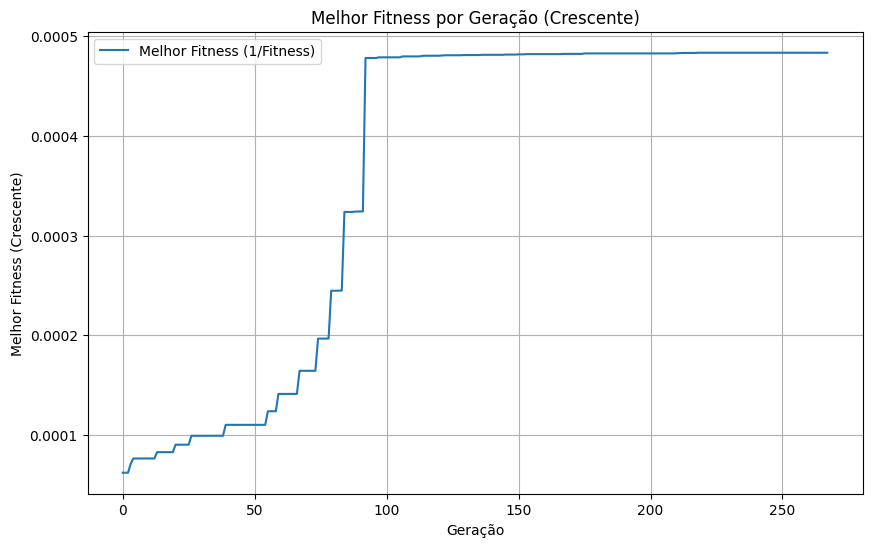

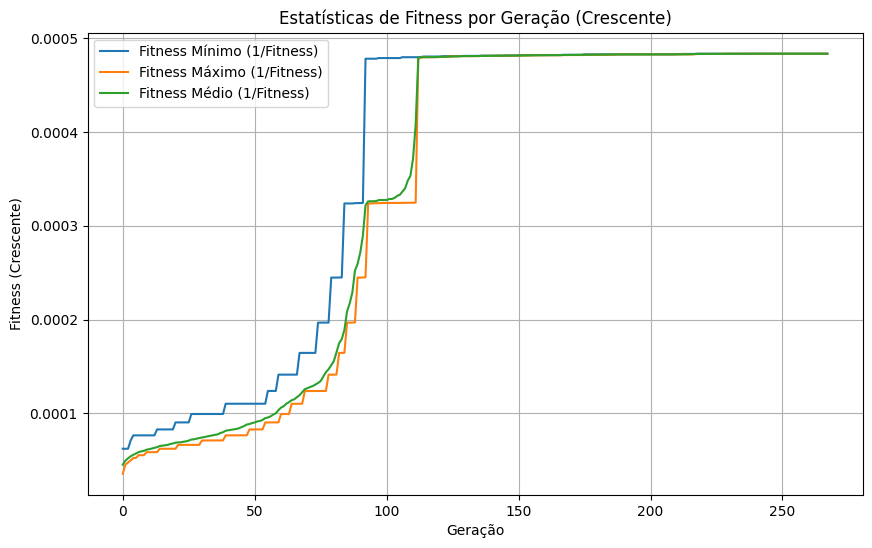

In [5]:
import matplotlib.pyplot as plt

# Função para plotar o melhor fitness por geração
def plotar_melhor_fitness(geracoes, melhor_fitness):
    melhor_fitness_crescente = [1 / fit for fit in melhor_fitness]
    plt.figure(figsize=(10, 6))
    plt.plot(geracoes, melhor_fitness_crescente, label='Melhor Fitness (1/Fitness)')
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness (Crescente)')
    plt.title('Melhor Fitness por Geração (Crescente)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Função para plotar min, max e média de fitness por geração
def plotar_estatisticas_fitness(geracoes, fitness_min, fitness_max, fitness_medio):
    fitness_min_crescente = [1 / fit for fit in fitness_min]
    fitness_max_crescente = [1 / fit for fit in fitness_max]
    fitness_medio_crescente = [1 / fit for fit in fitness_medio]
    
    plt.figure(figsize=(10, 6))
    plt.plot(geracoes, fitness_min_crescente, label='Fitness Mínimo (1/Fitness)')
    plt.plot(geracoes, fitness_max_crescente, label='Fitness Máximo (1/Fitness)')
    plt.plot(geracoes, fitness_medio_crescente, label='Fitness Médio (1/Fitness)')
    plt.xlabel('Geração')
    plt.ylabel('Fitness (Crescente)')
    plt.title('Estatísticas de Fitness por Geração (Crescente)')
    plt.legend()
    plt.grid(True)
    plt.show()


plotar_melhor_fitness(geracoes, melhor_fitness)
plotar_estatisticas_fitness(geracoes, fitness_min, fitness_max, fitness_medio)
